# FORECASTING PHILIPPINES INFLATION RATES (1994-2022)


In [59]:
#Import Datasets

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

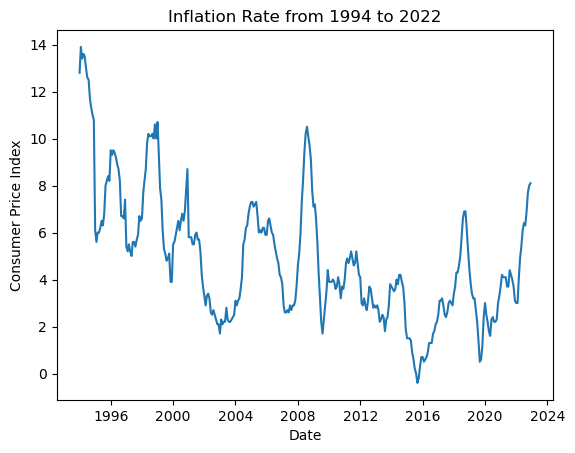

In [60]:
#Reading Datasets

df = pd.read_csv(r'C:\Users\Windows 10\Downloads\inflationph.csv', parse_dates = ['DATE'], index_col = ['DATE'])
df.head()
plt.xlabel('Date')
plt.ylabel('Consumer Price Index')
plt.title('Inflation Rate from 1994 to 2022')
plt.plot(df)

In [61]:
df.head()

,CPI
DATE,
1994-01-01,12.8
1994-02-01,13.9
1994-03-01,13.4
1994-04-01,13.6
1994-05-01,13.5


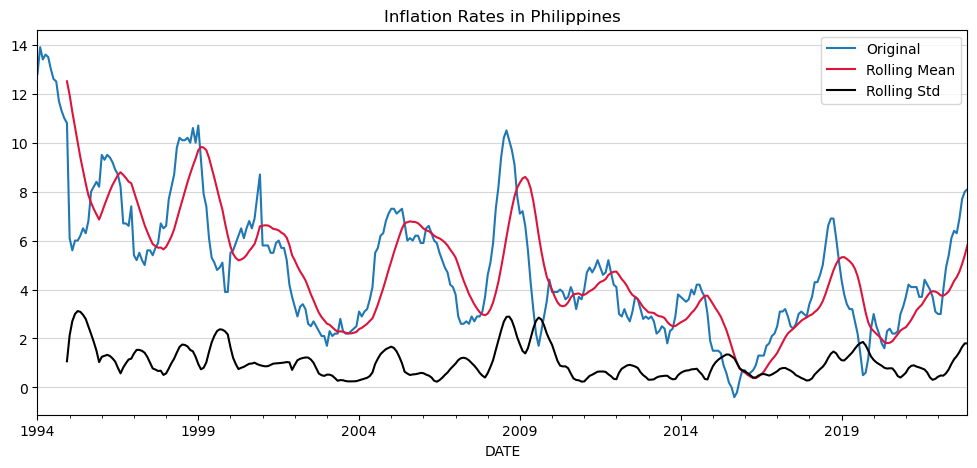

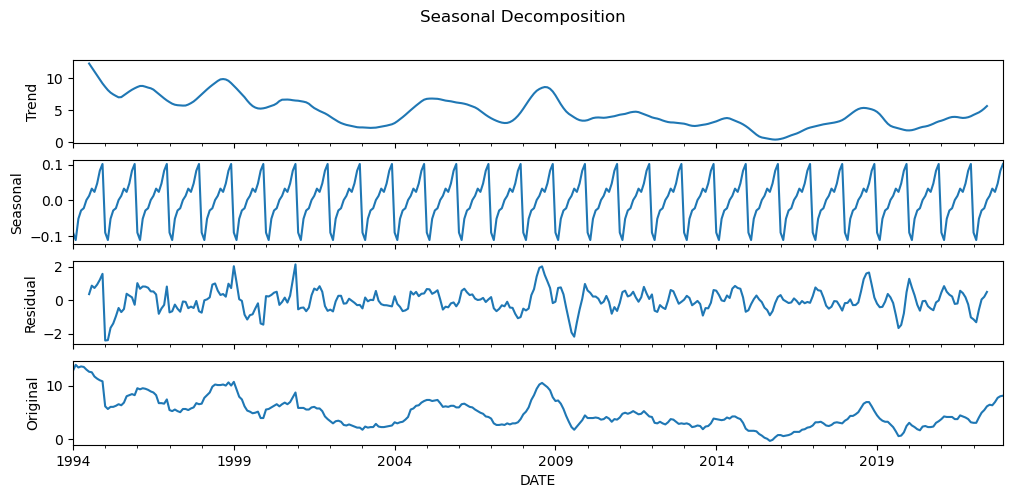

In [62]:
# visualize target data
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('Inflation Rates in Philippines')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(df['CPI'])

In [63]:
# ADF statistical test
def adf_test(series):
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(df['CPI'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -2.509480
2. P-value: 0.113185
3. Used Lags: 14
4. Used Observations: 333
5. Critical Values:
	1%: -3.450141
	5%: -2.870259
	10%: -2.571415

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [64]:
# Stationarizing Series
# perform data transformation
# series: must be a pandas dataframe
def series_transformation(series):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
    # 1st plot - data after transformation
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')
    
    # 2nd plot - partial autocorrelation plot
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=50, title='Autocorrelation')
    # plot 95% confidence intervals
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    
    # 3rd plot - partial autocorrelation plot
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=50, title='Partial Autocorrelation')
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle= '--', color= 'gray')
    plt.xlabel('lags')
    plt.show()
    
    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return

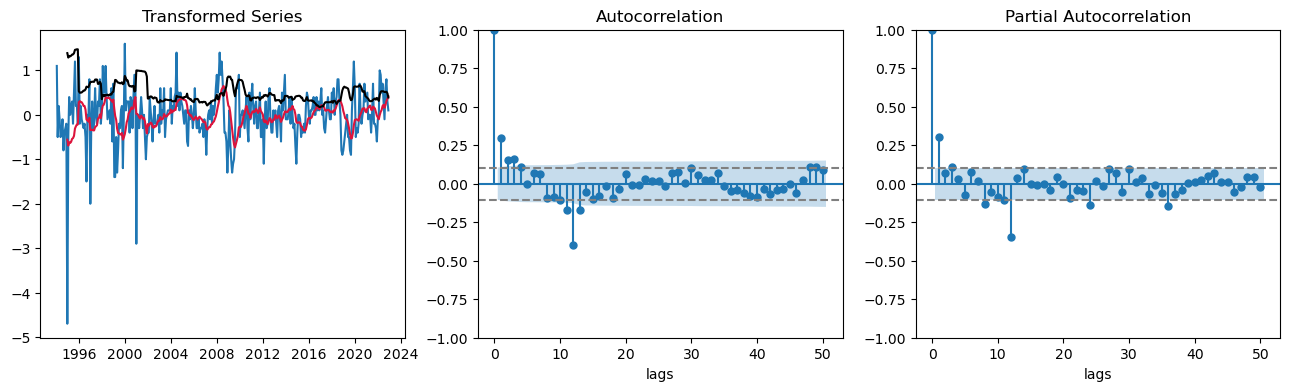

P-value = 0.000000, the series is likely stationary.


In [65]:
#first-order differencing

series_transformation(df.diff())

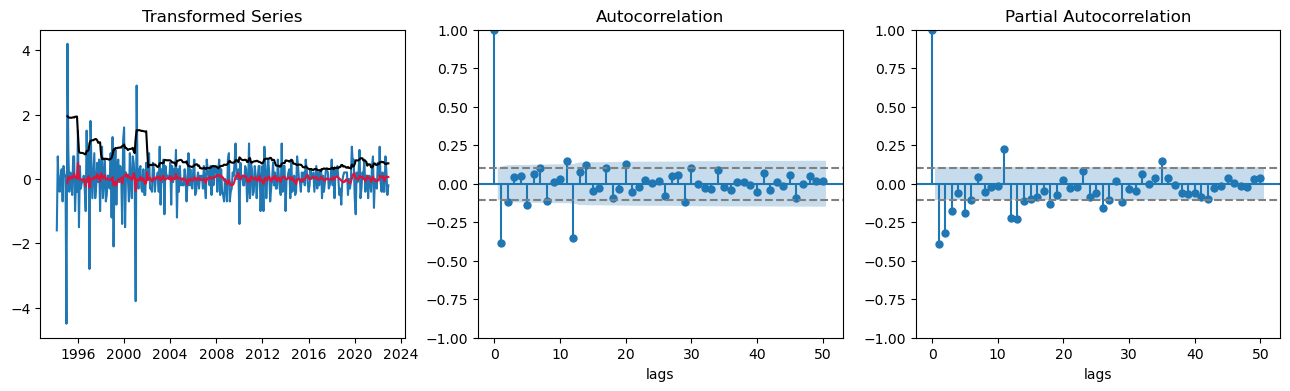

P-value = 0.000000, the series is likely stationary.


In [66]:
# second difference
series_transformation(df.diff().diff())

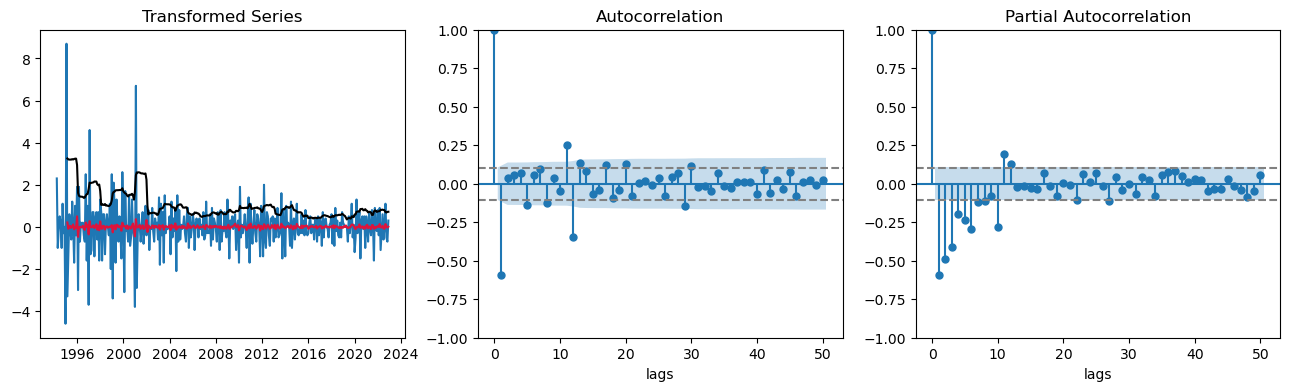

P-value = 0.000000, the series is likely stationary.


In [67]:
# third difference
series_transformation(df.diff().diff().diff())

In [68]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['CPI'],order = (1,1,1))
res1= model.fit()
print(res1.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  348
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -291.100
Date:                Fri, 30 Jun 2023   AIC                            588.200
Time:                        09:49:57   BIC                            599.748
Sample:                    01-01-1994   HQIC                           592.798
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6442      0.118      5.478      0.000       0.414       0.875
ma.L1         -0.3890      0.144     -2.696      0.007      -0.672      -0.106
sigma2         0.3133      0.009     36.697      0.0

In [69]:
model = ARIMA(df['CPI'],order = (1,1,1))
res1= model.fit()
print(res1.summary())
size = int(len(df) - 30)
train, test = df['CPI'][0:size], df['CPI'][size:len(df)] 

print('\t ARIMA MODEL : Inflation Rate in the Philippines \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                  348
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -291.100
Date:                Fri, 30 Jun 2023   AIC                            588.200
Time:                        09:50:11   BIC                            599.748
Sample:                    01-01-1994   HQIC                           592.798
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6442      0.118      5.478      0.000       0.414       0.875
ma.L1         -0.3890      0.144     -2.696      0.007      -0.672      -0.106
sigma2         0.3133      0.009     36.697      0.0

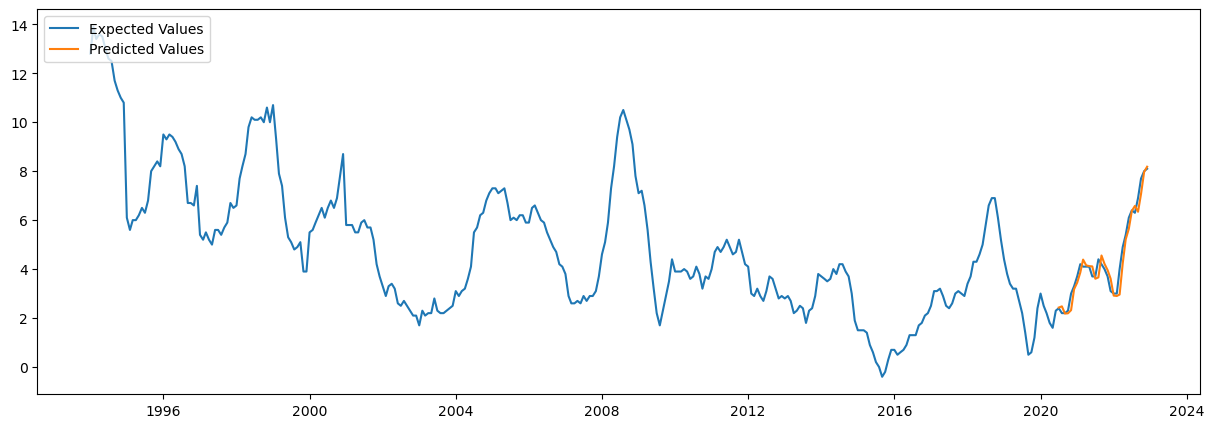

In [70]:
#plot train set

predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(df['CPI'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

error_rmse = np.sqrt(mean_squared_error(test, predictions))
error_mse = mean_squared_error(test, predictions)
error_mae = mean_absolute_error(test, predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error_mape = mean_absolute_percentage_error(test, predictions)
error_r2 = r2_score(test, predictions)

print('Test evaluation metrics:')
print(f'MSE: {error_mse:.4f}')
print(f'RMSE: {error_rmse:.4f}')
print(f'MAE: {error_mae:.4f}')
print(f'MAPE: {error_mape:.4f}')
print(f'R2: {error_r2:.4f}')

Test evaluation metrics:
MSE: 0.1544
RMSE: 0.3930
MAE: 0.2967
MAPE: 7.1999
R2: 0.9455


In [80]:
from pandas.tseries.offsets import DateOffset

# Generate future dates for the next 12 months
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 13)]

# Create a new DataFrame for storing the future values
forecast = pd.DataFrame(index=future_dates, columns=df.columns)

# Make predictions for the next 12 months
future_predictions = model_fit.forecast(steps=12)
forecast['ARIMA_Predict_Function'] = future_predictions

forecast.head()

,CPI,ARIMA_Predict_Function
2023-01-01,NaN,8.182357
2023-02-01,NaN,8.300068
2023-03-01,NaN,8.376050
2023-04-01,NaN,8.425096
2023-05-01,NaN,8.456755


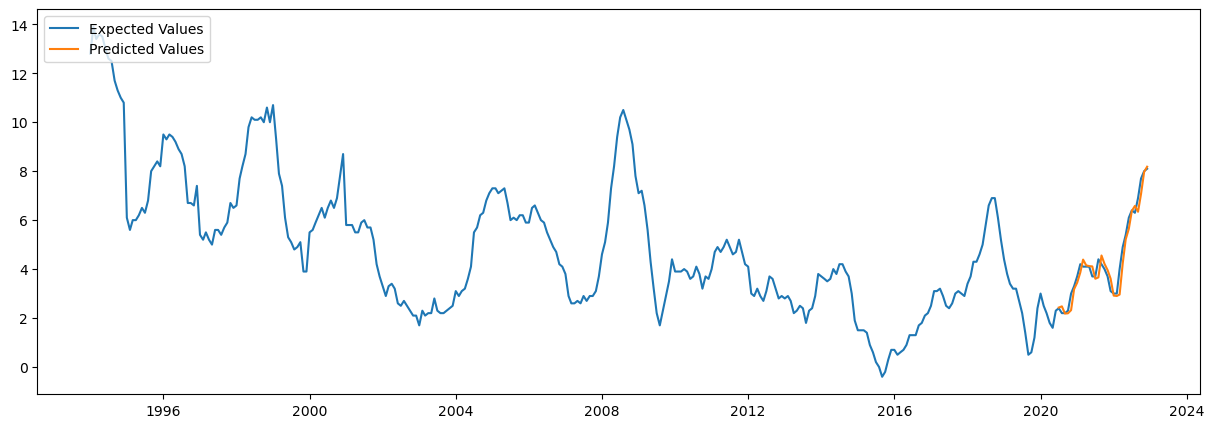

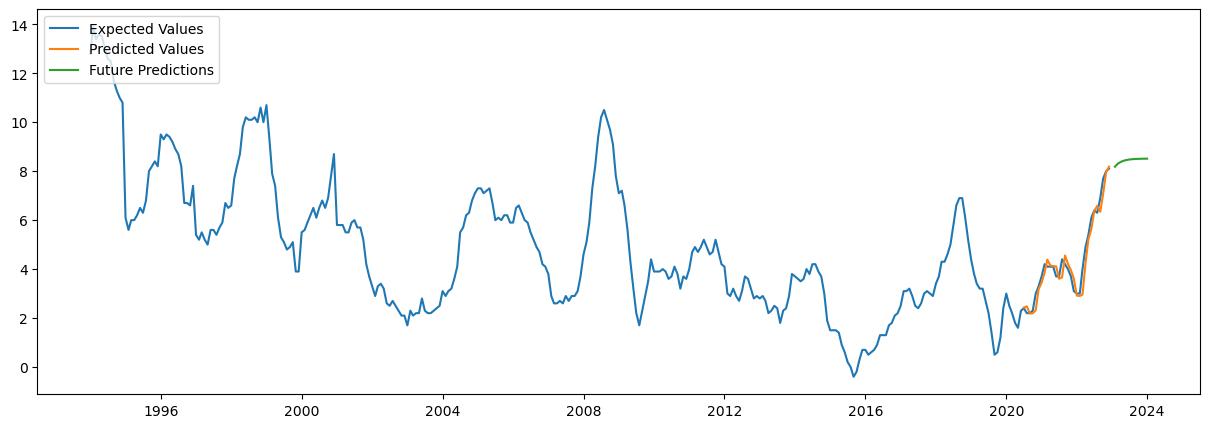

In [82]:
predictions_series = pd.Series(predictions, index=test.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.plot(df['CPI'], label='Expected Values')
plt.plot(predictions_series, label='Predicted Values')
plt.legend(loc="upper left")
plt.show()

# Step 3: Predict for the next year
future_periods = 12  # Number of future months to predict
future_index = pd.date_range(start=df.index[-1], periods=future_periods+1, freq='M')[1:]

future_predictions = model_fit.forecast(steps=future_periods)
future_predictions_series = pd.Series(future_predictions, index=future_index)

# Update the plot with the future predictions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.plot(df['CPI'], label='Expected Values')
plt.plot(predictions_series, label='Predicted Values')
plt.plot(future_predictions_series, label='Future Predictions')
plt.legend(loc="upper left")
plt.show()